In [1]:
from nerf import utils
from jax import device_put
import jax.numpy as jnp
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from visualhull import *


FLAGS = flags.FLAGS
utils.define_flags()
flags.DEFINE_integer("vsize", 400, "voxel size")
flags.DEFINE_integer("dilation", 7, "dilation size")
flags.DEFINE_float("thresh", 1., "threshold")
flags.DEFINE_integer("margin", 40, "margin")
flags.DEFINE_bool("test", False, "do test or not")
config.parse_flags_with_absl()

FLAGS.alpha_bkgd = True
FLAGS.num_rgb_channels = 4
FLAGS.config = "configs/blender"
FLAGS.data_dir = "../data/nerf_synthetic/lego"
FLAGS.voxel_dir = "../data/voxel_dil7/lego"

# FLAGS.alpha_bkgd = False
# FLAGS.num_rgb_channels = 3
# FLAGS.thresh = 0.9
# FLAGS.dilation = 11
# FLAGS.config = "configs/nsvf"
# FLAGS.data_dir = "../data/Synthetic_NSVF/Spaceship"
# FLAGS.voxel_dir = "../data/voxel_dil11/Spaceship"

FLAGS.test = True
utils.update_flags(FLAGS, no_nf=True)

class PureDataset(datasets.dataset_dict[FLAGS.dataset]):
    def start(self):
        pass

In [2]:
target = FLAGS.data_dir.split("/")[-1]

dataset = PureDataset("train", FLAGS)
dataset.images = dataset.images.reshape(-1,800,800,FLAGS.num_rgb_channels)
dataset.rays = dataset.rays._replace(
    origins=dataset.rays.origins.reshape(-1,800,800,3))
dataset.rays = dataset.rays._replace(
    directions=dataset.rays.directions.reshape(-1,800,800,3))
dataset.rays = dataset.rays._replace(
    viewdirs=dataset.rays.viewdirs.reshape(-1,800,800,3))

test_dataset = PureDataset("test", FLAGS)
test_dataset.images = test_dataset.images.reshape(-1,800,800,FLAGS.num_rgb_channels)
test_dataset.rays = test_dataset.rays._replace(
    origins=test_dataset.rays.origins.reshape(-1,800,800,3))
test_dataset.rays = test_dataset.rays._replace(
    directions=test_dataset.rays.directions.reshape(-1,800,800,3))
test_dataset.rays = test_dataset.rays._replace(
    viewdirs=test_dataset.rays.viewdirs.reshape(-1,800,800,3))

utils.update_flags(FLAGS, no_nf=not "nsvf" in FLAGS.config.lower())

2.0 6.0


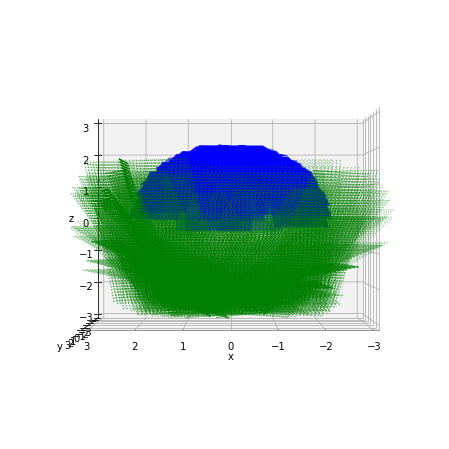

In [3]:
t_n, t_f = FLAGS.near, FLAGS.far
print(t_n, t_f)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
lim=3
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
# ax.view_init(elev=90, azim=90)
ax.view_init(elev=0, azim=90)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for idx in range(0, len(dataset.rays.origins), 2):
    o = dataset.rays.origins[idx]
    d = dataset.rays.directions[idx]

    # render lower limit（blue）
    x_n, y_n, z_n = (o + d * t_n)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_n, y_n, z_n, c='blue', s=0.1)

    # render upper limit (green)
    x_f, y_f, z_f = (o + d * t_f)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_f, y_f, z_f, c='green', s=0.1)

In [4]:
visualhull(FLAGS, dataset, test_dataset)

100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


uint8 (400, 400, 400) 
shape done!


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


float32 (400, 400, 400, 3) 
color done!


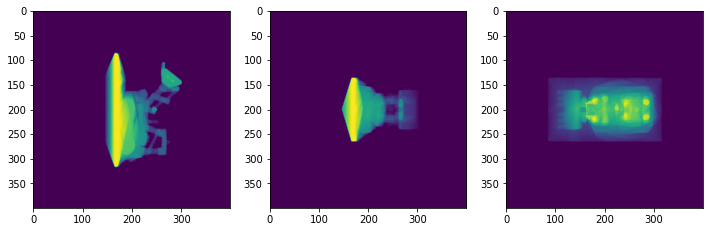

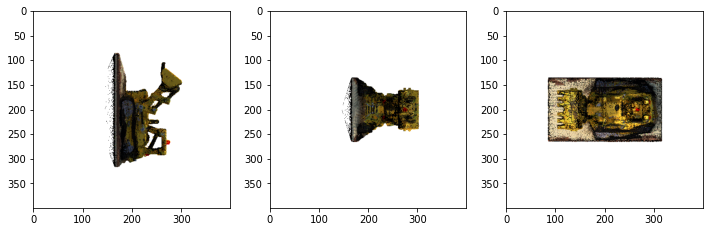

In [5]:
voxel = np.load(os.path.join(FLAGS.voxel_dir, "voxel.npy"))
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(np.sum(voxel, axis=0))
plt.subplot(1,3,2); plt.imshow(np.sum(voxel, axis=1))
plt.subplot(1,3,3); plt.imshow(np.sum(voxel, axis=2))
plt.show()

voxel_c = np.load(os.path.join(FLAGS.voxel_dir, "voxel_color.npy"))
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(np.min(voxel_c, axis=0))
plt.subplot(1,3,2); plt.imshow(np.min(voxel_c, axis=1))
plt.subplot(1,3,3); plt.imshow(np.min(voxel_c, axis=2))
plt.show()

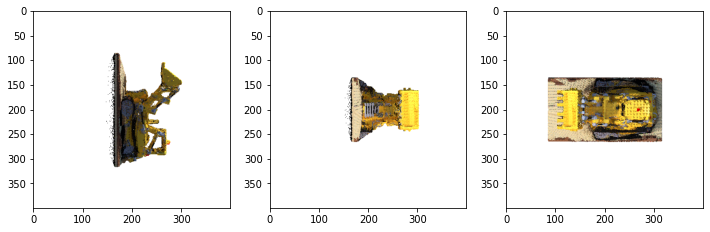

In [6]:
plt.figure(figsize=(12,4))

depth = voxel.argmax(axis=0)
depth = np.eye(FLAGS.vsize)[depth].transpose(2,0,1)
img = np.sum(voxel_c * depth[...,None], axis=0)
plt.subplot(1,3,1); plt.imshow(img)

depth = voxel.argmax(axis=1)
depth = np.eye(FLAGS.vsize)[depth].transpose(0,2,1)
img = np.sum(voxel_c * depth[...,None], axis=1)
plt.subplot(1,3,2); plt.imshow(img)

depth = np.flip(voxel, axis=2).argmax(axis=2)
depth = np.eye(FLAGS.vsize)[depth].transpose(0,1,2)
img = np.sum(np.flip(voxel_c, axis=2) * depth[...,None], axis=2)
plt.subplot(1,3,3); plt.imshow(img)

plt.show()